In [49]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

s = tf.InteractiveSession()

/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [48]:
import cv2

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
data = pd.read_csv('/content/drive/My Drive/DL-HW1/Q1_train.csv')

In [21]:
#Getting the labels
labels = data.iloc[:,0]
data.drop(columns = ['label'],inplace = True)
#standarizing
data = data/255

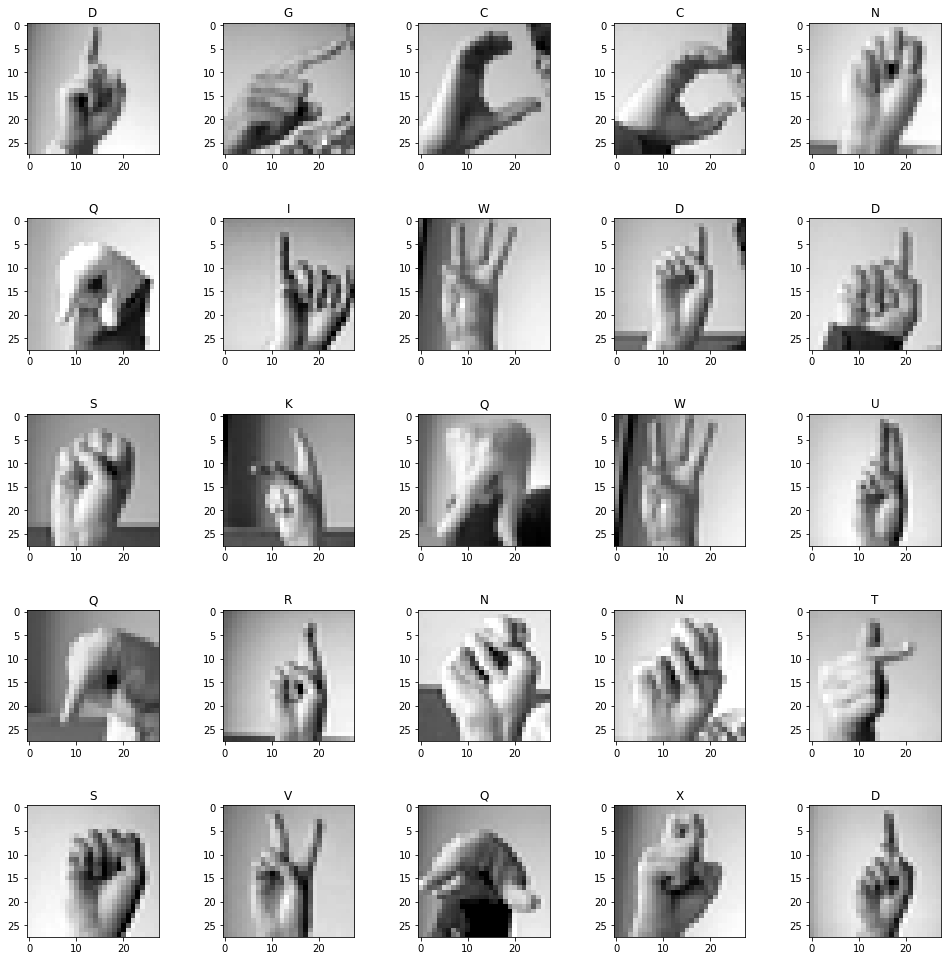

In [5]:
fig , ax = plt.subplots(nrows=5, ncols= 5, figsize = (14, 14))
ax = ax.flatten()
fig.tight_layout(pad=3.0)
for i, a in enumerate(ax):   
    a.imshow(data.values[i][:].reshape(28, 28), cmap = 'gray')
    a.set(title = string.ascii_letters[26+labels[i]])

In [22]:
#splitting the data
X_train, X_validation, y_train, y_validation = train_test_split(data, labels,test_size = 0.2, random_state = 123)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_validation = lb.transform(y_validation)

In [23]:
#features of model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
num_layers_2 = 128
starter_learning_rate = 0.0005
starter_learning_rate2 = 0.025

In [24]:
#inputs and outputs
X_in = tf.placeholder('float32',shape =(None,num_features),name="X_in")
y_in = tf.placeholder('float32',shape = (None,num_classes),name='y_in')

In [25]:
# Weights initialized by random normal function with std_dev = sqrt(4/(number of input features+ number of output features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(tf.sqrt(4/float(num_features + num_layers_0 )))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(tf.sqrt(4/float(num_layers_0 + num_layers_1)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_layers_2], stddev=(tf.sqrt(4/float(num_layers_1 + num_layers_2)))))
bias_2 = tf.Variable(tf.random_normal([num_layers_2]))
weights_3 = tf.Variable(tf.random_normal([num_layers_2,num_output], stddev=(1/tf.sqrt(float(num_layers_2)))))
bias_3 = tf.Variable(tf.random_normal([num_output]))

In [26]:
# Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(X_in,weights_0)   +bias_0)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0,weights_1)  +bias_1)
hidden_output_2 = tf.nn.relu(tf.matmul(hidden_output_1,weights_2) +bias_2)
y_pred = tf.sigmoid(tf.matmul(hidden_output_2,weights_3)+ bias_3)

In [27]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred,labels=y_in))
#learning rate of Dynamic type
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.95, staircase=True)
learning_rate2 = tf.train.exponential_decay(starter_learning_rate, 0, 4, 0.95, staircase=True)

# Note:
Take into note that learning rate is set dynamically and decays over the epoches so the learning process is done much more better!

In [28]:
# Adam optimzer for finding the right weight

#Two optimizers are set on our network at the first place 

optimizer_adam = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2, weights_3,
                                                                         bias_0,bias_1,bias_2, bias_3])
optimizer_sgd = tf.train.GradientDescentOptimizer(starter_learning_rate2).minimize(loss,var_list=[weights_0,weights_1,weights_2, weights_3,
                                                                         bias_0,bias_1,bias_2, bias_3])

In [29]:
#calculating accuaracy
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [30]:
#splitting train and test
X_train, X_validation= X_train.values, X_validation.values

In [ ]:
# Training parameters with adam optimizer and without Dropout
batch_size = 64
epochs= 20
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 2.61 Train acc: 0.350, Test acc:0.345
Epoch:1, Train loss: 2.48 Train acc: 0.493, Test acc:0.478
Epoch:2, Train loss: 2.43 Train acc: 0.591, Test acc:0.586
Epoch:3, Train loss: 2.40 Train acc: 0.647, Test acc:0.644
Epoch:4, Train loss: 2.37 Train acc: 0.678, Test acc:0.669
Epoch:5, Train loss: 2.36 Train acc: 0.724, Test acc:0.714
Epoch:6, Train loss: 2.34 Train acc: 0.742, Test acc:0.741
Epoch:7, Train loss: 2.33 Train acc: 0.783, Test acc:0.788
Epoch:8, Train loss: 2.31 Train acc: 0.832, Test acc:0.832
Epoch:9, Train loss: 2.33 Train acc: 0.802, Test acc:0.797
Epoch:10, Train loss: 2.30 Train acc: 0.861, Test acc:0.863
Epoch:11, Train loss: 2.29 Train acc: 0.899, Test acc:0.899
Epoch:12, Train loss: 2.32 Train acc: 0.838, Test acc:0.835
Epoch:13, Train loss: 2.30 Train acc: 0.894, Test acc:0.896
Epoch:14, Train loss: 2.30 Train acc: 0.905, Test acc:0.907
Epoch:15, Train loss: 2.29 Train acc: 0.911, Test acc:0.908
Epoch:16, Train loss: 2.28 Train acc: 0.928, Test 

# Note on accuaracy of model
> take into account that accuracy of model(train and test) in adam optimizer can go up to 0.93 depending on the random state we are in and in different running and is varaiable between 0.78 and 0.95



Train Accuracy: 0.94
Test Accuracy:0.94
Train Loss: 2.27
Test Loss:2.27


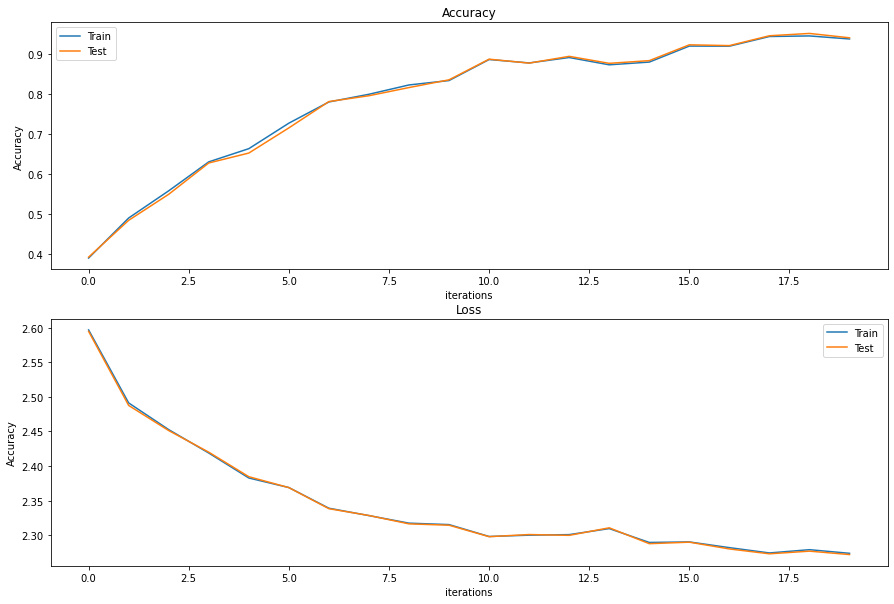

In [ ]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

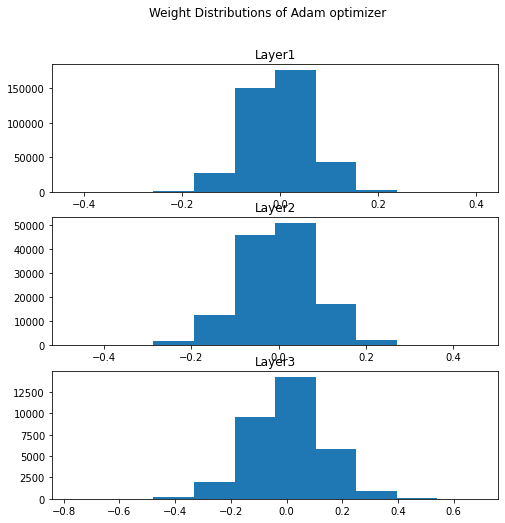

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    else : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of Adam optimizer');

In [ ]:
# Training parameters with sgd potimizer and without dropout
X_train = X_train + (0.35)*np.random.randn(X_train.shape[0],X_train.shape[1])
batch_size = 128
epochs=250
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
       s.run(optimizer_sgd, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    if epoch%10 == 0:
      print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 3.12 Train acc: 0.044, Test acc:0.043
Epoch:10, Train loss: 2.68 Train acc: 0.347, Test acc:0.419
Epoch:20, Train loss: 2.60 Train acc: 0.414, Test acc:0.503
Epoch:30, Train loss: 2.55 Train acc: 0.453, Test acc:0.525
Epoch:40, Train loss: 2.52 Train acc: 0.466, Test acc:0.547
Epoch:50, Train loss: 2.50 Train acc: 0.499, Test acc:0.586
Epoch:60, Train loss: 2.47 Train acc: 0.531, Test acc:0.616
Epoch:70, Train loss: 2.46 Train acc: 0.551, Test acc:0.639
Epoch:80, Train loss: 2.44 Train acc: 0.571, Test acc:0.658
Epoch:90, Train loss: 2.43 Train acc: 0.595, Test acc:0.688
Epoch:100, Train loss: 2.43 Train acc: 0.586, Test acc:0.665
Epoch:110, Train loss: 2.41 Train acc: 0.614, Test acc:0.699
Epoch:120, Train loss: 2.40 Train acc: 0.628, Test acc:0.719
Epoch:130, Train loss: 2.40 Train acc: 0.631, Test acc:0.713
Epoch:140, Train loss: 2.38 Train acc: 0.650, Test acc:0.740
Epoch:150, Train loss: 2.38 Train acc: 0.658, Test acc:0.747
Epoch:160, Train loss: 2.38 Train a

Train Accuracy: 0.72
Test Accuracy:0.79
Train Loss: 2.34
Test Loss:2.37


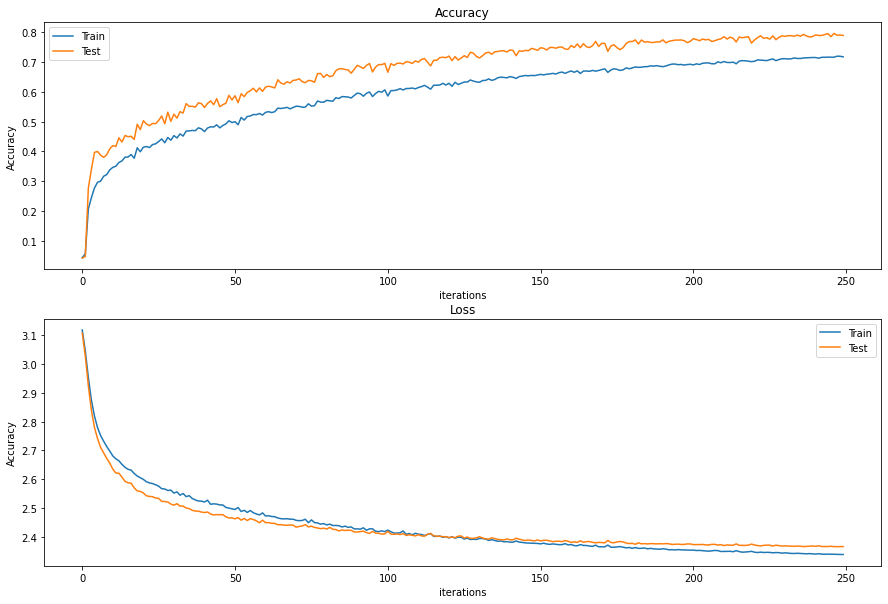

In [ ]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

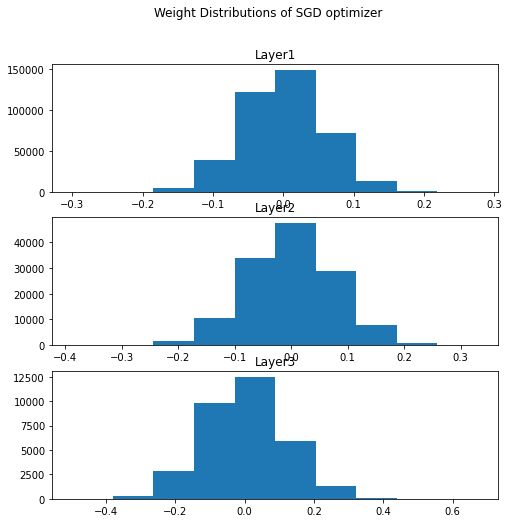

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    else : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of SGD optimizer');

In [41]:
#adding Dropout to the model
keep_prob = tf.placeholder(tf.float32)
hidden_output_0 = tf.nn.relu(tf.matmul(X_in,weights_0)   +bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,weights_1)  +bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)
hidden_output_2 = tf.nn.relu(tf.matmul(hidden_output_1_1,weights_2) +bias_2)
hidden_output_2_2 = tf.nn.dropout(hidden_output_2, keep_prob)
y_pred = tf.sigmoid(tf.matmul(hidden_output_2_2,weights_3)+ bias_3)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
#tuning parameters with dropout and adam optimizer
batch_size = 64
epochs=19
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam , {X_in: X_train[arr[index:index+batch_size]],
                          y_in: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train,keep_prob:1}))
    
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation,keep_prob:1}))
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation,keep_prob:1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 2.59 Train acc: 0.444, Test acc:0.440
Epoch:1, Train loss: 2.50 Train acc: 0.516, Test acc:0.516
Epoch:2, Train loss: 2.43 Train acc: 0.596, Test acc:0.593
Epoch:3, Train loss: 2.40 Train acc: 0.654, Test acc:0.647
Epoch:4, Train loss: 2.37 Train acc: 0.723, Test acc:0.721
Epoch:5, Train loss: 2.34 Train acc: 0.765, Test acc:0.757
Epoch:6, Train loss: 2.33 Train acc: 0.790, Test acc:0.785
Epoch:7, Train loss: 2.33 Train acc: 0.797, Test acc:0.793
Epoch:8, Train loss: 2.32 Train acc: 0.831, Test acc:0.834
Epoch:9, Train loss: 2.30 Train acc: 0.856, Test acc:0.854
Epoch:10, Train loss: 2.31 Train acc: 0.858, Test acc:0.855
Epoch:11, Train loss: 2.30 Train acc: 0.872, Test acc:0.877
Epoch:12, Train loss: 2.31 Train acc: 0.875, Test acc:0.873
Epoch:13, Train loss: 2.31 Train acc: 0.858, Test acc:0.862
Epoch:14, Train loss: 2.28 Train acc: 0.919, Test acc:0.921
Epoch:15, Train loss: 2.28 Train acc: 0.929, Test acc:0.932
Epoch:16, Train loss: 2.30 Train acc: 0.890, Test 

Train Accuracy: 0.95
Test Accuracy:0.96
Train Loss: 2.27
Test Loss:2.27


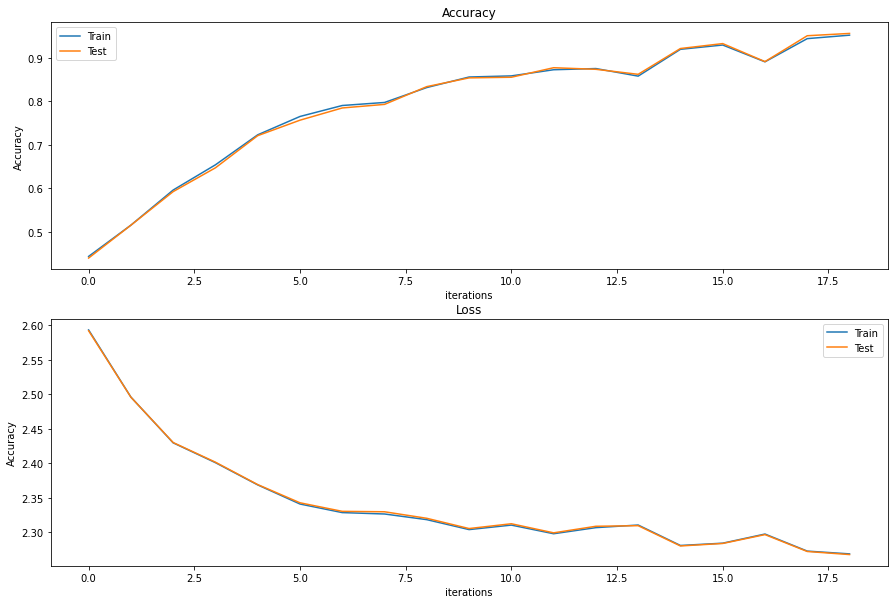

In [ ]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

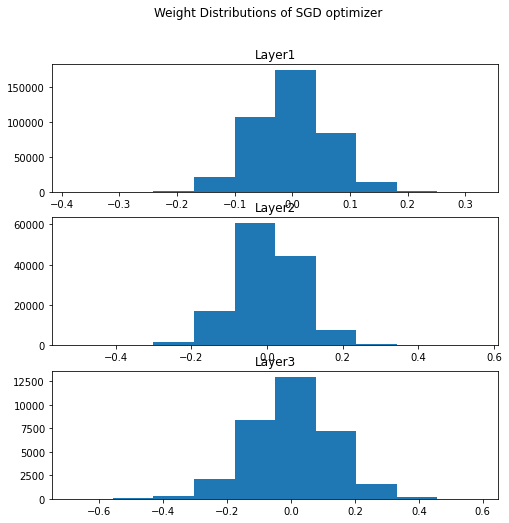

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    else : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of SGD optimizer');

In [ ]:
# Training parameters with dropout and sgd optimizer
X_train = X_train + (0.35)*np.random.randn(X_train.shape[0],X_train.shape[1])
batch_size = 128
epochs=250
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
       s.run(optimizer_sgd, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:], keep_prob:dropout_prob} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train, keep_prob:1}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train, keep_prob:1}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation, keep_prob:1}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation, keep_prob:1}))
    if epoch%10 == 0:
      print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 3.12 Train acc: 0.104, Test acc:0.153
Epoch:10, Train loss: 2.68 Train acc: 0.319, Test acc:0.358
Epoch:20, Train loss: 2.61 Train acc: 0.380, Test acc:0.423
Epoch:30, Train loss: 2.56 Train acc: 0.441, Test acc:0.504
Epoch:40, Train loss: 2.53 Train acc: 0.461, Test acc:0.524
Epoch:50, Train loss: 2.50 Train acc: 0.503, Test acc:0.568
Epoch:60, Train loss: 2.48 Train acc: 0.521, Test acc:0.597
Epoch:70, Train loss: 2.46 Train acc: 0.543, Test acc:0.616
Epoch:80, Train loss: 2.44 Train acc: 0.576, Test acc:0.644
Epoch:90, Train loss: 2.43 Train acc: 0.583, Test acc:0.651
Epoch:100, Train loss: 2.43 Train acc: 0.602, Test acc:0.673
Epoch:110, Train loss: 2.41 Train acc: 0.617, Test acc:0.697
Epoch:120, Train loss: 2.40 Train acc: 0.627, Test acc:0.695
Epoch:130, Train loss: 2.39 Train acc: 0.638, Test acc:0.714
Epoch:140, Train loss: 2.39 Train acc: 0.645, Test acc:0.723
Epoch:150, Train loss: 2.38 Train acc: 0.658, Test acc:0.729
Epoch:160, Train loss: 2.37 Train a

In [ ]:
#a try to ragularize on bias terms
regularizer_rate = 0.1
loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred,labels=y_in)) + + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)) + tf.reduce_sum(tf.square(bias_2)))
optimizer_adam_2 = tf.train.AdamOptimizer(learning_rate).minimize(loss_2,var_list=[weights_0,weights_1,weights_2, weights_3,
                                                                         bias_0,bias_1,bias_2, bias_3])

In [ ]:
batch_size = 64
epochs= 20
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam_2, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 2.61 Train acc: 0.415, Test acc:0.420
Epoch:1, Train loss: 2.51 Train acc: 0.437, Test acc:0.440
Epoch:2, Train loss: 2.46 Train acc: 0.557, Test acc:0.557
Epoch:3, Train loss: 2.40 Train acc: 0.650, Test acc:0.636
Epoch:4, Train loss: 2.39 Train acc: 0.664, Test acc:0.655
Epoch:5, Train loss: 2.34 Train acc: 0.752, Test acc:0.749
Epoch:6, Train loss: 2.34 Train acc: 0.771, Test acc:0.767
Epoch:7, Train loss: 2.33 Train acc: 0.798, Test acc:0.792
Epoch:8, Train loss: 2.31 Train acc: 0.834, Test acc:0.831
Epoch:9, Train loss: 2.30 Train acc: 0.850, Test acc:0.844
Epoch:10, Train loss: 2.31 Train acc: 0.847, Test acc:0.846
Epoch:11, Train loss: 2.35 Train acc: 0.788, Test acc:0.786
Epoch:12, Train loss: 2.32 Train acc: 0.829, Test acc:0.826
Epoch:13, Train loss: 2.28 Train acc: 0.910, Test acc:0.911
Epoch:14, Train loss: 2.29 Train acc: 0.898, Test acc:0.897
Epoch:15, Train loss: 2.30 Train acc: 0.873, Test acc:0.871
Epoch:16, Train loss: 2.28 Train acc: 0.918, Test 

In [36]:
training = tf.placeholder_with_default(False, shape = (), name = 'training')

In [43]:
w_0= tf.constant_initializer((np.sqrt(4/float(num_features + num_layers_0 ))) * np.random.randn(num_features,num_layers_0))
ww_0 = tf.layers.dense(X_in, num_layers_0, use_bias=True)
batchNorm_0 = tf.layers.batch_normalization(ww_0, training=training, momentum=0.9)
batchNorm_0_d = tf.nn.dropout(batchNorm_0, keep_prob)
batchNorm_0_act = tf.nn.relu(batchNorm_0_d)


w_1 = tf.constant_initializer((np.sqrt(4/float(num_layers_0 + num_layers_1))) * np.random.randn(num_layers_0,num_layers_1))
ww_1 = tf.layers.dense(batchNorm_0_act, num_layers_1, use_bias=True)
batchNorm_1 = tf.layers.batch_normalization(ww_1, training=training, momentum=0.9)
batchNorm_1_d = tf.nn.dropout(batchNorm_1, keep_prob)
batchNorm_1_act = tf.nn.relu(batchNorm_1_d)


w_2 = tf.constant_initializer((np.sqrt(4/float(num_layers_1 + num_layers_2))) * np.random.randn(num_layers_1,num_layers_2))
ww_2 = tf.layers.dense(batchNorm_1_act, num_layers_2,  use_bias=True)
batchNorm_2 = tf.layers.batch_normalization(ww_2, training=training, momentum=0.9)
batchNorm_2_d = tf.nn.dropout(batchNorm_2, keep_prob)
batchNorm_2_act = tf.nn.relu(batchNorm_2_d)


w_3 = tf.constant_initializer((np.sqrt(1/float(num_layers_2))) * np.random.randn(num_layers_2,num_output))
ww_3 = tf.layers.dense(batchNorm_2_act, num_output,  use_bias=True)
batchNorm_3 = tf.layers.batch_normalization(ww_3, training=training, momentum=0.9)
batchNorm_3_d = tf.nn.dropout(batchNorm_3, keep_prob)
batchNorm_3_act = tf.sigmoid(batchNorm_3_d)


In [44]:
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [46]:

batch_size = 64
epochs= 40
dropout_prob = 0.55
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam,feed_dict =  {X_in: X_train[arr[index:index+batch_size]][:],
                                           y_in: y_train[arr[index:index+batch_size]][:],
                                           training : True, keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train, keep_prob:1}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train, keep_prob:1}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation, keep_prob:1}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation, keep_prob:1}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 2.60 Train acc: 0.376, Test acc:0.370
Epoch:1, Train loss: 2.50 Train acc: 0.488, Test acc:0.487
Epoch:2, Train loss: 2.44 Train acc: 0.588, Test acc:0.575
Epoch:3, Train loss: 2.40 Train acc: 0.628, Test acc:0.624
Epoch:4, Train loss: 2.36 Train acc: 0.737, Test acc:0.737
Epoch:5, Train loss: 2.35 Train acc: 0.745, Test acc:0.745
Epoch:6, Train loss: 2.32 Train acc: 0.795, Test acc:0.798
Epoch:7, Train loss: 2.32 Train acc: 0.811, Test acc:0.813
Epoch:8, Train loss: 2.31 Train acc: 0.844, Test acc:0.839
Epoch:9, Train loss: 2.32 Train acc: 0.838, Test acc:0.837
Epoch:10, Train loss: 2.30 Train acc: 0.853, Test acc:0.848
Epoch:11, Train loss: 2.30 Train acc: 0.881, Test acc:0.884
Epoch:12, Train loss: 2.29 Train acc: 0.908, Test acc:0.905
Epoch:13, Train loss: 2.30 Train acc: 0.896, Test acc:0.892
Epoch:14, Train loss: 2.28 Train acc: 0.925, Test acc:0.927
Epoch:15, Train loss: 2.28 Train acc: 0.930, Test acc:0.929
Epoch:16, Train loss: 2.28 Train acc: 0.930, Test 

In [31]:
s_0 = tf.summary.scalar(name = 'loss', tensor = accuracy)

In [35]:
batch_size = 64
epochs= 20
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./logs', s.graph)
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]})
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

InvalidArgumentError: ignored

In [51]:
a = tf.Variable(2, dtype=tf.float32)
b = a+2
c = a+3
s.run(tf.global_variables_initializer())
g, f = s.run([b, c])